# NCAA tournament data - Neural Network

In [1]:
#for saving and load data files
import pickle
import numpy as np
import train as train
import neuralnetworks as nn
import matplotlib.pyplot as plt
%matplotlib inline
import matplotlib.figure
import copy

### Loading NCAA Data

In [2]:
#objects to store data
gameYearData = {} #dictionary with year as key and value is a list of lists containing [team1,team2,overall score] for everygame played by tournament teams
#example: '2000': [['Duke', 'Lamar', 137], ['Kansas', 'DePaul', 158]]

tournamentGameData = {}#dictionary with year as key and value is a list of lists containing [team1,team2,overall score] for everygame in the tournament
#example: '2000': [['Duke', 'Lamar', 137], ['Kansas', 'DePaul', 158]]

teamYearData = {} #dictionary with year as key and value is a dictionary with team as key and value in the form of [[team stats],[opponent stats]] 
#team/oppenent stats: [0G, 1MP, 2FG, 3FGA, 4FG%, 52P, 62PA, 72P%, 83P, 93PA, 103P%, 11FT, 12FTA, 13FT%, 14ORB, 15DRB, 16TRB, 17AST, 18STL, 19BLK, 20TOV, 21PF, 22PTS, 23PTS/G]
#example: '2000': {'Duke': [[34, '', 1045, 2172, 0.481, 761, 1430, 0.532, 284, 742, 0.383, 618, 833, 0.742, 453, 860, 1313, 584, 333, 191, 480, 552, 2992, 88.0], [34, '', 934, 2238, 0.417, 737, 1686, 0.437, 197, 552, 0.357, 360, 537, 0.67, 526, 757, 1283, 472, 240, 123, 607, 690, 2425, 71.3]]}

In [3]:
#webscraping has already been run and the data is saved in files: tournamentGameData.pickle, teamYearData.pickle
#open dicts from file

pickle_in1 = open("teamYearData.pickle","rb")
teamYearData = pickle.load(pickle_in1)

pickle_in2 = open("gameYearData.pickle","rb")
gameYearData = pickle.load(pickle_in2)

pickle_in3 = open("tournamentGameData.pickle","rb")
tournamentGameData = pickle.load(pickle_in3)

In [4]:
#Read in Information about the Over Under values for NCAA Tournament games saved in file valid_classification_games.pkl
#This information looks like (team,opponent,over_under score, Outcome) 
#Outcome = 0 for Under
#Outcome = 1 for Over
over_under_data = []
with open("valid_classification_games.pkl","rb") as f:
    over_under_data = pickle.load(f)

### Data Formatting Functions

In [5]:
def removeTournamentGamesFromData(year): 
    
    newGameYearData=copy.deepcopy(gameYearData)
    newGameYearData[year] = []
    
    for game in gameYearData[year]:
        duplicate = False
        for gameCompare in tournamentGameData[year]:
            if game[2] == gameCompare[2]:
                if (game[0]==gameCompare[0] and game[1]==gameCompare[1]) or (game[1]==gameCompare[0] and game[0]==gameCompare[1]):
                    duplicate = True
        if not duplicate:
            newGameYearData[year].append(game)

    return newGameYearData

In [41]:
def formatData(yearRange,gameData,acceptedOpponentStats=[]):
    #formatting data for use in nn
    acceptedTeamStats = [2,3,4,5,6,7,8,9,10,11,12,13,16,17,18,19,23]
    if acceptedOpponentStats == []:
        acceptedOpponentStats = [2,3,4,5,6,7,8,9,10,11,12,13,16,17,18,19,20,23]

    years = [i for i in range(yearRange[0],yearRange[1]+1)]

    data = []

    for i in years:
        year = str(i)
        singleSeason = gameData[year]
        singleYearTeamData = teamYearData[year]
    
        for game in singleSeason:
            finalScore = game[2]
            teamStats = []
            for j in range(0,2):
                tempTeamStats = singleYearTeamData[game[j]][0]
                tempOpponentStats = singleYearTeamData[game[j]][1]
                for q in range(0,24):
                    if q in acceptedTeamStats:
                        if tempTeamStats[q]=='':
                            print((year,game[j],q))
                        teamStats.append(tempTeamStats[q])
                    if q in acceptedOpponentStats:
                        if tempOpponentStats[q]=='':
                            print((year,game[j],q))
                        teamStats.append(tempOpponentStats[q])
            teamStats.append(finalScore)
            data.append(teamStats)
            
    formattedData = np.array(data)
    return formattedData

In [100]:
def format_classification_data(over_under):
    acceptedTeamStats = [4,10,12,13,16,17,20,23]
    acceptedOpponentStats = [4,10,12,13,16,17,20,23]
    data = []
    for game in over_under:
        year = game[0][2][-4:]
        singleYearTeamData = teamYearData[year]
        teamStats = []
        try:
            tempTeamStats = singleYearTeamData[game[0][0]][0]
            tempOpponentStats = singleYearTeamData[game[0][1]][0]
            for q in range(0,24):
                    if q in acceptedTeamStats:
                        teamStats.append(tempTeamStats[q])
                    if q in acceptedOpponentStats:
                        teamStats.append(tempOpponentStats[q])
            teamStats.append(game[0][4])
            data.append(teamStats)
        except KeyError:
            print("error")
    over = []
    under = []
    for item in data:
        if item[-1] == 1.0:
            over.append(item)
        else:
            under.append(item)
    sort_data = over+under
    return np.array(sort_data)

In [65]:
print(classification_data)

[[  0.469   0.437   0.397 ...,  75.     59.3     1.   ]
 [  0.455   0.428   0.35  ...,  66.3    70.2     1.   ]
 [  0.453   0.458   0.341 ...,  71.1    72.9     0.   ]
 ..., 
 [  0.486   0.425   0.381 ...,  78.9    70.      1.   ]
 [  0.491   0.425   0.402 ...,  71.     70.      0.   ]
 [  0.483   0.458   0.362 ...,  78.     79.7     0.   ]]


### Formatting Data for use in the Nueral Networks

In [21]:
gameYearData_without2017TourneyData = removeTournamentGamesFromData('2017')

In [36]:
testData = formatData([2017,2017],tournamentGameData)
testTdata = testData[:,-1]
testTdata = np.row_stack(testTdata)
testXdata = testData[:,0:-1]
testTdata.shape, testXdata.shape

((63, 1), (63, 72))

In [22]:
trainData_from2010 = formatData([2010,2017],gameYearData_without2017TourneyData)
trainTdata_from2010 = trainData_from2010[:,-1]
trainTdata_from2010 = np.row_stack(trainTdata_from2010)
trainXdata_from2010 = trainData_from2010[:,0:-1]
trainTdata_from2010.shape, trainXdata_from2010.shape

((15154, 1), (15154, 72))

In [24]:
trainAllData_from2010 = formatData([2010,2017],gameYearData)
trainAllTdata_from2010 = trainAllData_from2010[:,-1]
trainAllTdata_from2010 = np.row_stack(trainAllTdata_from2010)
trainAllXdata_from2010 = trainAllData_from2010[:,0:-1]
trainAllTdata_from2010.shape, trainAllXdata_from2010.shape

((15216, 1), (15216, 72))

In [42]:
testData_from1996 = formatData([2017,2017],tournamentGameData,[23])
testTdata_from1996 = testData_from1996[:,-1]
testTdata_from1996 = np.row_stack(testTdata)
testXdata_from1996 = testData_from1996[:,0:-1]
testTdata_from1996.shape, testXdata_from1996.shape

((63, 1), (63, 36))

In [26]:
trainData_from1996 = formatData([1996,2017],gameYearData_without2017TourneyData,[23])
trainTdata_from1996 = trainData_from1996[:,-1]
trainTdata_from1996 = np.row_stack(trainTdata_from1996)
trainXdata_from1996 = trainData_from1996[:,0:-1]
trainTdata_from1996.shape, trainXdata_from1996.shape

((40064, 1), (40064, 36))

In [27]:
trainAllData_from1996 = formatData([1996,2017],gameYearData,[23])
trainAllTdata_from1996 = trainAllData_from1996[:,-1]
trainAllTdata_from1996 = np.row_stack(trainAllTdata_from1996)
trainAllXdata_from1996 = trainAllData_from1996[:,0:-1]
trainAllTdata_from1996.shape, trainAllXdata_from1996.shape

((40126, 1), (40126, 36))

## Neural Network Testing

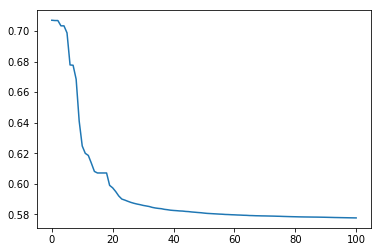

In [28]:
nnet = nn.NeuralNetwork(trainXdata.shape[1], [3,3,3,3,3], trainTdata.shape[1])
nnet.train(trainXdata, trainTdata, 100)
plt.plot(nnet.getErrorTrace())

In [29]:
iterations = 100
repetitions = 10
nns = [0,2,5,[4,4],[5,5],[1,1,1,1],[3,3,3,3],[3,3,3,3,3]]

#### Training neural network with all games from the 2010-2016 seasons and the regular season of 2017 as training data and with all tournament games from the 2017 season as testing data

0 done
2 done
5 done
[4, 4] done
[5, 5] done
[1, 1, 1, 1] done
[3, 3, 3, 3] done
[3, 3, 3, 3, 3] done

Summary
[0, 15.899638379840791, 14.743187772834625, 3.7306692600250244]
[2, 15.876248535348484, 14.756397282391344, 39.76994204521179]
[5, 15.781614809042292, 14.863901024988646, 41.87262725830078]
[[4, 4], 15.814052530949317, 14.940736046381573, 48.72788715362549]
[[5, 5], 15.778330458721138, 15.048866962605505, 47.48056674003601]
[[1, 1, 1, 1], 16.052292346560765, 14.778223220442545, 37.17359685897827]
[[3, 3, 3, 3], 15.876210447581784, 14.836321499230923, 57.34011173248291]
[[3, 3, 3, 3, 3], 15.87394387285579, 14.925680767110345, 58.945926904678345]

Best
[0, 15.899638379840791, 14.743187772834625, 3.7306692600250244]



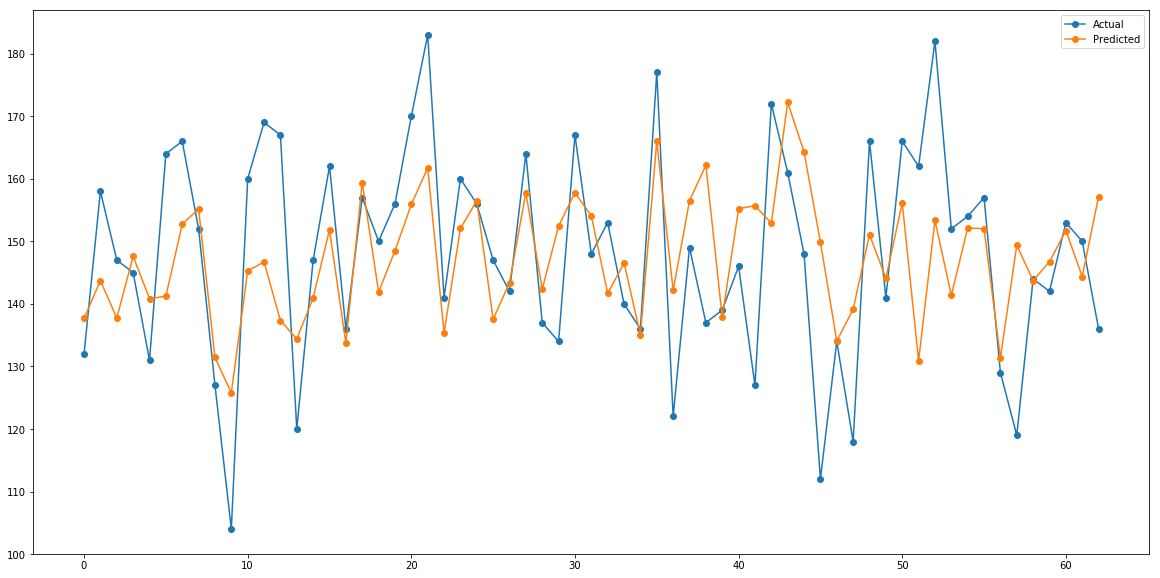

In [30]:
results = train.trainNNsWithTrainData(trainXdata_from2010, trainTdata_from2010, testXdata,testTdata, nns, repetitions, iterations)
print("")

print("Summary")
summary = train.summarize(results)
for temp in summary:
    print(temp)
print("")
    
print("Best")
best = train.bestNetwork(summary)
print(best)
print("")

nnet = nn.NeuralNetwork(trainXdata_from2010.shape[1], best[0], trainTdata_from2010.shape[1])
nnet.train(trainXdata_from2010, trainTdata_from2010, nIterations=iterations)
YtestData = nnet.use(testXdata)

plt.figure(figsize=(20,10))
plt.plot(testTdata[:,0],'o-',label="Actual")
plt.plot(YtestData[:,0],'o-',label="Predicted")
plt.legend()

#### Training neural network with all games from the 1996-2016 seasons and the regular season of 2017 as training data and with all tournament games from the 2017 season as testing data

0 done
2 done
5 done
[4, 4] done
[5, 5] done
[1, 1, 1, 1] done
[3, 3, 3, 3] done
[3, 3, 3, 3, 3] done

Summary
[0, 16.197923815751459, 15.140505783838639, 4.942212820053101]
[2, 16.207607767926078, 15.103562557629427, 57.12936282157898]
[5, 16.187120431748053, 15.11842064675788, 60.13499331474304]
[[4, 4], 16.192531239193876, 15.074067112114893, 72.7766580581665]
[[5, 5], 16.185537398020099, 15.08299744692188, 87.1660680770874]
[[1, 1, 1, 1], 16.262243759439205, 15.078845909943004, 49.99156594276428]
[[3, 3, 3, 3], 16.210554985763849, 15.068115266794212, 86.96944189071655]
[[3, 3, 3, 3, 3], 16.221984254393991, 15.027823772937154, 96.70780777931213]

Best
[[3, 3, 3, 3, 3], 16.221984254393991, 15.027823772937154, 96.70780777931213]



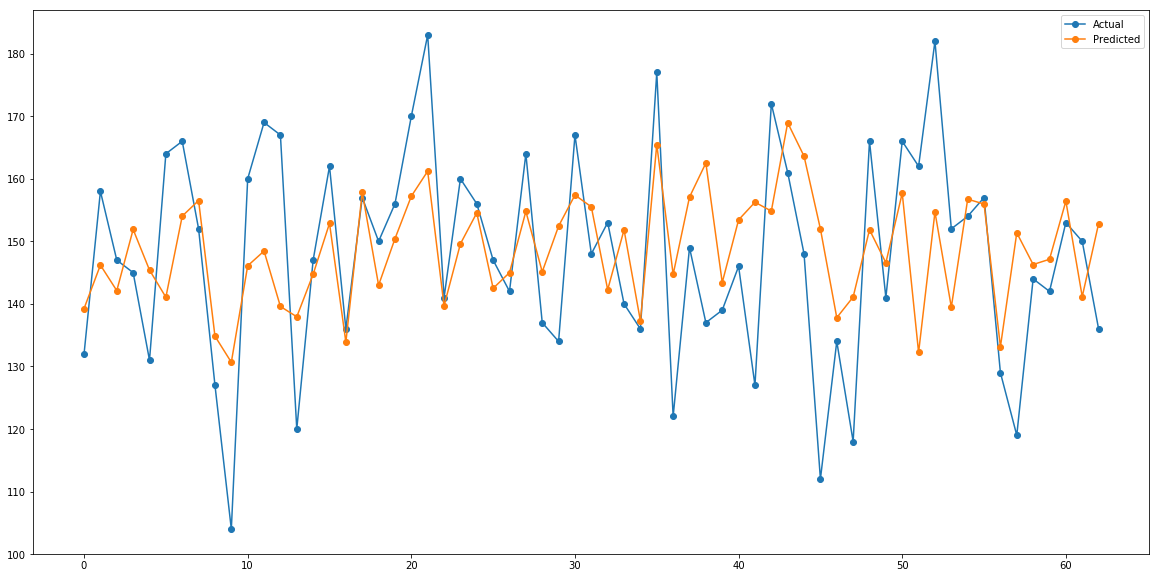

In [43]:
results = train.trainNNsWithTrainData(trainXdata_from1996, trainTdata_from1996, testXdata_from1996,testTdata_from1996, nns, repetitions, iterations)
print("")

print("Summary")
summary = train.summarize(results)
for temp in summary:
    print(temp)
print("")
    
print("Best")
best = train.bestNetwork(summary)
print(best)
print("")

nnet = nn.NeuralNetwork(trainXdata_from1996.shape[1], best[0], trainTdata_from1996.shape[1])
nnet.train(trainXdata_from1996, trainTdata_from1996, nIterations=iterations)
YtestData = nnet.use(testXdata_from1996)

plt.figure(figsize=(20,10))
plt.plot(testTdata_from1996[:,0],'o-',label="Actual")
plt.plot(YtestData[:,0],'o-',label="Predicted")
plt.legend()

#### Training neural network with 80% of games from the 2010-2017 seasons as training data and with the remaining 20% as testing data

0 done
2 done
5 done
[4, 4] done
[5, 5] done
[1, 1, 1, 1] done
[3, 3, 3, 3] done
[3, 3, 3, 3, 3] done

Summary
[0, 15.88696141309234, 15.970588782050948, 2.9116499423980713]
[2, 15.867215218736286, 15.992817597019428, 33.914507150650024]
[5, 15.751338634402947, 16.095605183964881, 37.064945936203]
[[4, 4], 15.784558072424108, 16.088609181241214, 39.175946950912476]
[[5, 5], 15.710505018729759, 16.23960767420018, 45.92112731933594]
[[1, 1, 1, 1], 16.050595093245366, 16.203161717034568, 26.693975925445557]
[[3, 3, 3, 3], 15.828488099910638, 16.102442792215136, 41.225537061691284]
[[3, 3, 3, 3, 3], 15.879346278523276, 16.043493639630441, 43.610121965408325]

Best
[0, 15.88696141309234, 15.970588782050948, 2.9116499423980713]



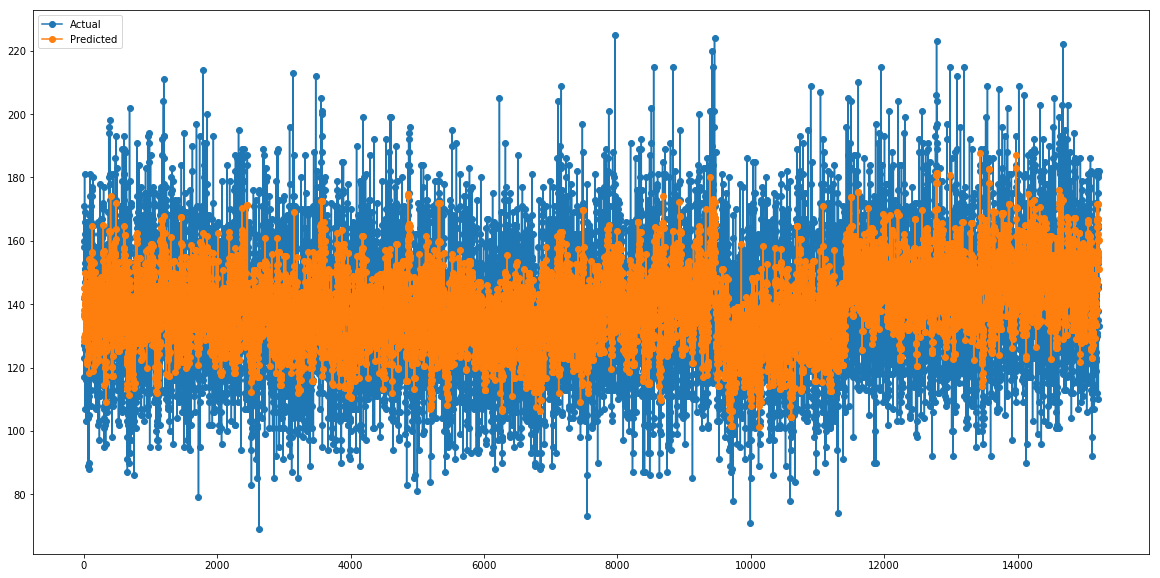

In [31]:
results = train.trainNNs(trainAllXdata_from2010, trainAllTdata_from2010, .8, nns, repetitions, iterations)
print("")

print("Summary")
summary = train.summarize(results)
for temp in summary:
    print(temp)
print("")
    
print("Best")
best = train.bestNetwork(summary)
print(best)
print("")

nnet = nn.NeuralNetwork(trainAllXdata_from2010.shape[1], best[0], trainAllTdata_from2010.shape[1])
nnet.train(trainAllXdata_from2010, trainAllTdata_from2010, nIterations=iterations)
YtestData = nnet.use(trainAllXdata_from2010)

plt.figure(figsize=(20,10))
plt.plot(trainAllTdata_from2010[:,0],'o-',label="Actual")
plt.plot(YtestData[:,0],'o-',label="Predicted")
plt.legend()

#### Training neural network with 80% of games from the 1996-2017 seasons as training data and with the remaining 20% as testing data

0 done
2 done
5 done
[4, 4] done
[5, 5] done
[1, 1, 1, 1] done
[3, 3, 3, 3] done
[3, 3, 3, 3, 3] done

Summary
[0, 16.190734691417912, 16.226672965007928, 5.032736778259277]
[2, 16.205633994014313, 16.207481357031035, 44.06221294403076]
[5, 16.177650168859625, 16.223034358004405, 47.549834966659546]
[[4, 4], 16.173637437380489, 16.28260863135306, 55.937262773513794]
[[5, 5], 16.176125194782884, 16.241820046287291, 65.03045105934143]
[[1, 1, 1, 1], 16.312968812470746, 16.389328825231175, 40.58403515815735]
[[3, 3, 3, 3], 16.199913286916789, 16.263121891102056, 69.7206482887268]
[[3, 3, 3, 3, 3], 16.216782557436385, 16.220902149339416, 76.49683618545532]

Best
[2, 16.205633994014313, 16.207481357031035, 44.06221294403076]



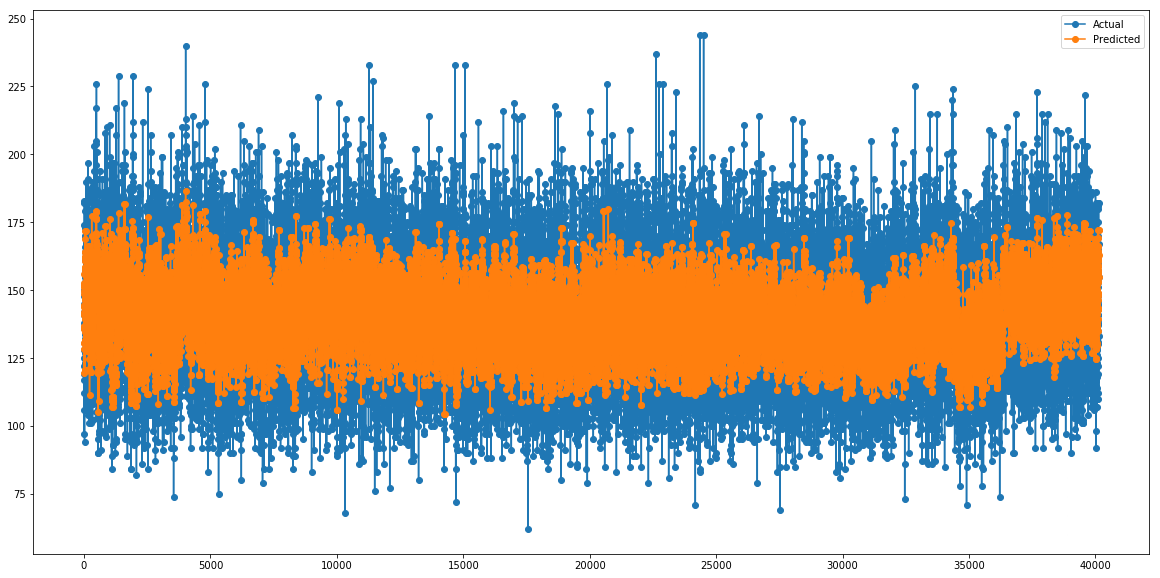

In [44]:
results = train.trainNNs(trainAllXdata_from1996, trainAllTdata_from1996, .8, nns, repetitions, iterations)
print("")

print("Summary")
summary = train.summarize(results)
for temp in summary:
    print(temp)
print("")
    
print("Best")
best = train.bestNetwork(summary)
print(best)
print("")

nnet = nn.NeuralNetwork(trainAllXdata_from1996.shape[1], best[0], trainAllTdata_from1996.shape[1])
nnet.train(trainAllXdata_from1996, trainAllTdata_from1996, nIterations=iterations)
YtestData = nnet.use(trainAllXdata_from1996)

plt.figure(figsize=(20,10))
plt.plot(trainAllTdata_from1996[:,0],'o-',label="Actual")
plt.plot(YtestData[:,0],'o-',label="Predicted")
plt.legend()

### Neural Networking testing with classification

In [113]:
trainAllData = format_classification_data(over_under_data)
trainAllTdata = trainAllData[:,-1]
trainAllTdata = np.row_stack(trainAllTdata)
trainAllXdata = trainAllData[:,0:-1]
trainAllTdata.shape, trainAllXdata.shape

((196, 1), (196, 16))

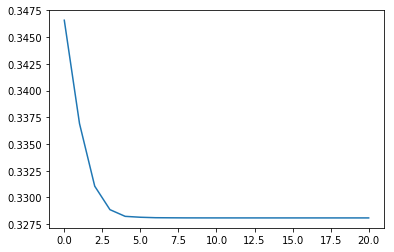

In [114]:
nnet = nn.NeuralNetworkClassifier(trainAllXdata.shape[1], [0], trainAllTdata.shape[1]+1)
nnet.train(trainAllXdata, trainAllTdata, 20)
plt.plot(nnet.getErrorTrace())

In [115]:
iterations = 10
repetitions = 20
nns = [0,2,5,[4,4],[5,5],[1,1,1,1],[3,3,3,3],[3,3,3,3,3]]

0 done
2 done
5 done
[4, 4] done
[5, 5] done
[1, 1, 1, 1] done
[3, 3, 3, 3] done
[3, 3, 3, 3, 3] done

Summary
[0, 0.38407643312101913, 0.50641025641025639, 0.09686279296875]
[2, 0.35000000000000003, 0.53461538461538471, 0.12298393249511719]
[5, 0.34299363057324844, 0.50641025641025639, 0.12654900550842285]
[[4, 4], 0.37993630573248416, 0.52051282051282044, 0.12987327575683594]
[[5, 5], 0.37420382165605104, 0.51025641025641022, 0.175933837890625]
[[1, 1, 1, 1], 0.41433121019108282, 0.50641025641025639, 0.1644282341003418]
[[3, 3, 3, 3], 0.39490445859872614, 0.51666666666666672, 0.32581281661987305]
[[3, 3, 3, 3, 3], 0.40382165605095544, 0.52564102564102577, 0.24054384231567383]

Best
[0, 0.38407643312101913, 0.50641025641025639, 0.09686279296875]

Percent Error:  0.40306122449


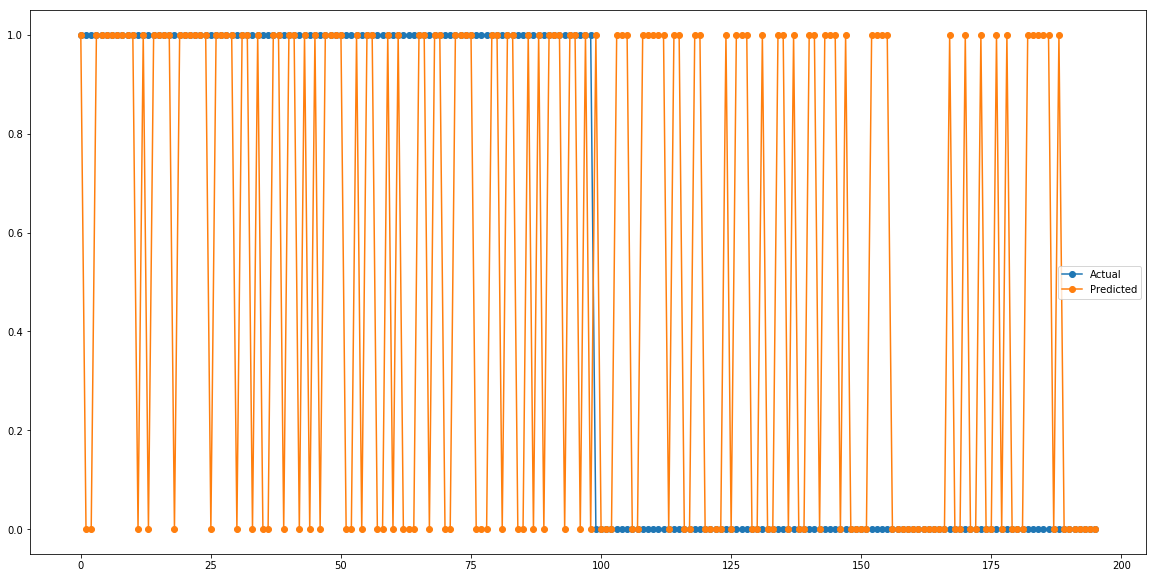

In [121]:
results = train.trainNNs(trainAllXdata, trainAllTdata, .8, nns, repetitions, iterations, True)
print("")

print("Summary")
summary = train.summarize(results)
for temp in summary:
    print(temp)
print("")
    
print("Best")
best = train.bestNetwork(summary)
print(best)
print("")

nnet = nn.NeuralNetworkClassifier(trainAllXdata.shape[1], best[0], trainAllTdata.shape[1]+1)
nnet.train(trainAllXdata, trainAllTdata, nIterations=iterations)
YtestData = nnet.use(trainAllXdata)
plt.figure(figsize=(20,10))
plt.plot(trainAllTdata[:,0],'o-',label="Actual")
plt.plot(YtestData[:,0],'o-',label="Predicted")
plt.legend()
print("Percent Error: ",(np.sum(np.abs(YtestData - trainAllTdata)))/trainAllTdata.shape[0])